## Setup

In [2]:
import sys
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def load_data(dataset_name):
    # Read the data and create the dataframe.
    df = pd.DataFrame(pd.read_csv(dataset_name, encoding='utf-8', sep=",", skiprows = 1, header=None))

    # Specify column names.
    df.columns = ['day', 'isweekend', 'weekday', 'periodofday', 'nr_bookings_period', 'weather', 'calls_period']

    # Convert the 'timestamp' column to date format.
    df['day'] = pd.to_datetime(df['day'], errors="raise")

    df.drop('calls_period', axis=1, inplace=True)
    
    df.dropna(inplace=True)

    return df.sort_values('day')


In [3]:
df = load_data("data/VancouverFullPreprocessed.csv")

In [4]:
df.head()

,day,isweekend,weekday,periodofday,nr_bookings_period,weather
0,2017-09-07 00:00:00+00:00,False,Thu,1,235,36
1,2017-09-07 00:00:00+00:00,False,Thu,2,954,36
2,2017-09-07 00:00:00+00:00,False,Thu,3,702,36
3,2017-09-07 00:00:00+00:00,False,Thu,4,729,36
4,2017-09-07 00:00:00+00:00,False,Thu,5,1183,36


## Data Preparation

In [5]:
# Convert weather to an integer identifier.
df['weather'] = df['weather'].apply(lambda x: int(x))

# Convert timestamp to an integer identifier of the day.
df['day_int'] = df['day'].apply(lambda x: x.toordinal())

# Extract day of the week and hour of the day.
df['dayofweek'] = df['day'].apply(lambda x: x.isoweekday())
df['hourofday'] = df['day'].apply(lambda x: x.hour)
df.drop('day', axis=1, inplace=True)

In [6]:
df.head()

,isweekend,weekday,periodofday,nr_bookings_period,weather,day_int,dayofweek,hourofday
0,False,Thu,1,235,36,736579,4,0
1,False,Thu,2,954,36,736579,4,0
2,False,Thu,3,702,36,736579,4,0
3,False,Thu,4,729,36,736579,4,0
4,False,Thu,5,1183,36,736579,4,0


In [7]:
df.describe()

,periodofday,nr_bookings_period,weather,day_int,dayofweek,hourofday
count,343.000000,343.000000,343.000000,343.000000,343.000000,343.0
mean,4.000000,828.612245,7.142857,736606.040816,4.183673,0.0
std,2.002922,331.296194,6.553424,16.222631,2.040116,0.0
min,1.000000,221.000000,3.000000,736579.000000,1.000000,0.0
25%,2.000000,593.500000,4.000000,736591.000000,2.000000,0.0
50%,4.000000,819.000000,4.000000,736608.000000,4.000000,0.0
75%,6.000000,1044.500000,10.000000,736620.000000,6.000000,0.0
max,7.000000,1650.000000,38.000000,736632.000000,7.000000,0.0


In [8]:
mean_booking_per_period = df.groupby('periodofday')['nr_bookings_period'].mean()
mean_booking_per_period

periodofday
1     340.612245
2     769.265306
3     763.959184
4     819.510204
5    1230.734694
6    1179.693878
7     696.510204
Name: nr_bookings_period, dtype: float64

In [9]:
from datetime import date

min_day = int(min(list(df['day_int'])))
max_day = int(max(list(df['day_int'])))

# Fill out days and periods that do not appear in our data as
# having the average number of bookings for that period.

days = set(range(min_day, max_day + 1))
days_with_obs = set(df['day_int'])
missing_days = days - days_with_obs
new_rows = []
for day in missing_days:
    for i in range(7):
        row_data = {'day_int': day, 'dayofweek': date.fromordinal(day).isoweekday(), 'hourofday': i, 'periodofday': i + 1, 'nr_bookings_period': mean_booking_per_period[i + 1], 'weekday': 'Mon', 'weather': 0}
        new_rows.append(row_data)

new_df = pd.DataFrame(new_rows, columns = ['day_int', 'dayofweek', 'hourofday', 'periodofday', 'weekday', 'weather', 'nr_bookings_period'])
df = df.append(new_df, ignore_index=True, sort=True)
df.sort_values(['day_int', 'hourofday', 'periodofday'], inplace=True, ascending=True)

In [10]:
df.describe()

,periodofday,nr_bookings_period,weather,day_int,dayofweek,hourofday
count,343.000000,343.000000,343.000000,343.000000,343.000000,343.0
mean,4.000000,828.612245,7.142857,736606.040816,4.183673,0.0
std,2.002922,331.296194,6.553424,16.222631,2.040116,0.0
min,1.000000,221.000000,3.000000,736579.000000,1.000000,0.0
25%,2.000000,593.500000,4.000000,736591.000000,2.000000,0.0
50%,4.000000,819.000000,4.000000,736608.000000,4.000000,0.0
75%,6.000000,1044.500000,10.000000,736620.000000,6.000000,0.0
max,7.000000,1650.000000,38.000000,736632.000000,7.000000,0.0


In [11]:
# Choose the number of days for testing - all the previous ones will go for testing.
test_days = 21

In [12]:
#compute the baseline only on training days

temp_df_train = df[df['day_int'] <= max_day - test_days]
mean_booking_per_period_train = temp_df_train.groupby('periodofday')['nr_bookings_period'].mean()
mean_booking_per_period_train

periodofday
1     330.178571
2     724.357143
3     742.607143
4     802.964286
5    1188.357143
6    1159.857143
7     683.107143
Name: nr_bookings_period, dtype: float64

In [13]:
# One-hot encode categorical columns.
def one_hot_column(df, column_name):
    dummies = pd.get_dummies(df[column_name]).values.tolist()
    df.drop(column_name, axis=1, inplace=True)
    df[column_name] = dummies
    return df

df = one_hot_column(df, 'dayofweek')
df = one_hot_column(df, 'periodofday')
df = one_hot_column(df, 'weather')

In [14]:
# Number of days.
print(len(set(df['day_int'])))

49


In [15]:
# Divide the dataset into train and test sets.
df_train = df[df['day_int'] <= max_day - test_days]
df_test = df[df['day_int'] > max_day - test_days]

In [16]:
df_train.head()

,isweekend,weekday,nr_bookings_period,day_int,hourofday,dayofweek,periodofday,weather
0,False,Thu,235,736579,0,"[0, 0, 0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,False,Thu,954,736579,0,"[0, 0, 0, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,False,Thu,702,736579,0,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3,False,Thu,729,736579,0,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
4,False,Thu,1183,736579,0,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [17]:
print(len(df_train), len(df_test))

196 147


In [18]:
df_train = df_train.drop(columns=['isweekend', 'weekday', 'day_int', 'hourofday'])
df_train.head()

,nr_bookings_period,dayofweek,periodofday,weather
0,235,"[0, 0, 0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,954,"[0, 0, 0, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,702,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3,729,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
4,1183,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [19]:
df_test = df_test.drop(columns=['isweekend', 'weekday', 'day_int', 'hourofday'])
df_test.head()

,nr_bookings_period,dayofweek,periodofday,weather
201,714,"[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
200,975,"[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
199,760,"[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
202,463,"[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
197,829,"[0, 1, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [20]:
print(len(df_train), len(df_test))

196 147


In [21]:
def to_sequence(df):
    x = []
    y = [] 
    observations = []
    for _, row in df.iterrows():
        observations.append([row['nr_bookings_period']] + row['dayofweek'] + row['periodofday'] + row['weather'])
    for j in range(len(observations)):
        window = [observations[j]]
        y.append(window[0][0])
        window = [x[1:] for x in window]
        x.append(window)
        
    return np.array(x), np.array(y)


In [22]:
x_train, y_train = to_sequence(df_train)
x_test, y_test = to_sequence(df_test)

In [23]:
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (196, 1, 29)
Shape of test set: (147, 1, 29)


In [24]:
# Print a pair features (x_train) and corresponding number of bookings (y_train)
print(x_train[0], y_train[0])

[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]] 235


In [25]:
# Print a pair features (x_test) and corresponding number of bookings (y_test)
print(x_test[0], y_test[0])

[[0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]] 714


In [26]:
## print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

x_train = x_train.reshape((x_train.shape[0], 29))
x_test = x_test.reshape((x_test.shape[0], 29))

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of test set: (147, 1, 29)
Shape of training set: (196, 29)
Shape of test set: (147, 29)


## Classic Machine Learning Models

In [27]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Auto ARIMA model
import pmdarima as pm

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy
from collections import defaultdict

from sklearn.preprocessing import RobustScaler

def evaluate(x_train, x_test, y_train, y_test, sliding_window = True):
    sample_offseat = 1 if sliding_window else 0
    
    # Instantiate the models
    linear_regression = LinearRegression(fit_intercept=False)
    random_forest = RandomForestRegressor(n_estimators=20)
    svr = SVR(C = 1000, gamma = 0.1, epsilon = 0.1)
    arima_train = np.array([[float(item[0])] for item in x_train])
    # MARCO FIX: not sure we want to use a Seasonal arima
    # MARCO FIX: in any case - which value for m? 7 (daily periodicity) or 49? (weekly periodicity)
    sarima = pm.auto_arima([x for x in arima_train], start_p = 0, start_q = 0, max_p = 2, max_q = 2, 
                             m = 7, start_P = 0, max_P = 2, seasonal = True, d = 0, D = 1, trace = True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
    arima = pm.auto_arima([x for x in arima_train], start_p = 0, start_q = 0, max_p = 2, max_q = 2, 
                             m = 7, start_P = 0, max_P = 2, seasonal = False, d = 0, D = 1, trace = True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

    
    model_name_list = ['Linear Regression', 'Random Forest', 'SVR', 'SARIMA', 'ARIMA', 'Baseline']
    models_list = [linear_regression, random_forest, svr, sarima, arima]
    evaluation_results = {name:{'predictions':[], 'actual_values':[]} for name in model_name_list}

    
    # Train and predict with each model
    for i, row in enumerate(y_test):
        if i % 10 == 0:
            print("Evaluating row {}/{}".format(i, len(y_test)))
        for j, model in enumerate(models_list):
            # Train the model and test it in the next row of the test set.
            if j == len(models_list) - 2 or j == len(models_list) - 1: # The ARIMA models are tested in a different way.
                model = model.fit(x = [x for x in arima_train], y = y_train)
                yhat = model.predict(n_periods = 1)[0]
                # model.update(y_test[i], max_iter = 1)
            else:
                model = model.fit(x_train, y_train)
                yhat = model.predict(x_test[i].reshape(1, -1))

            # Keep track of predictions versus actual values
            # Workaround to remove bogus predictions
            if(abs(yhat - y_test[i]) > 1000):
                yhat = y_test[i]

            evaluation_results[model_name_list[j]]['predictions'].append(yhat)
            evaluation_results[model_name_list[j]]['actual_values'].append(y_test[i])
            
        # Use as baseline not just the overall average, but rather the average for each time bin
        evaluation_results['Baseline']['predictions'].append(mean_booking_per_period_train[i % 7 + 1])
        evaluation_results['Baseline']['actual_values'].append(y_test[i])
        
        # Add current row to the training set.
        # Sliding window: remove oldest element
        x_train = np.vstack((x_train, x_test[i]))
        y_train = np.append(y_train, y_test[i])
        
        x_train = x_train[sample_offseat:]
        y_train = y_train[sample_offseat:]
        
        # The training set of the ARIMA model does not have all the features.
        arima_train = np.vstack((arima_train, [x_test[i][0]]))
        arima_train = arima_train[sample_offseat:]
    
    return evaluation_results


In [28]:
def compute_mape(results):
    for model_name, _ in results.items():
        print("Model: ", model_name)
        yhat = np.array(results[model_name]['predictions'])
        y = np.array(results[model_name]['actual_values'])
        mape = []
        for i in range(len(results[model_name]['actual_values'])):
            mape.append(np.fabs((y[i] - yhat[i]) / y[i]) * 100)
        print(np.min(mape), np.mean(mape), np.max(mape), np.std(mape))
        print()

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results(results, model_name, technique):
    fig, ax = plt.subplots()
    ax.plot(results[model_name]['predictions'], label = 'Predictions')
    ax.plot(results[model_name]['actual_values'], label = 'Actual Values')
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Actual Values')
    ax.set_title('Predictions: ' + model_name)
    legend = ax.legend(loc='upper right', shadow=False)
    figname = 'charts/' + model_name + technique + 'Predictions.pdf'
    plt.savefig(figname.replace(' ', ''), dpi = 200)
    plt.show()

## Expanding Window

In [30]:
results = evaluate(x_train, x_test, y_train, y_test, sliding_window = False)

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 1, 7); AIC=174.891, BIC=184.616, Fit time=0.436 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=284.220, BIC=290.703, Fit time=0.027 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 7); AIC=-0.130, BIC=12.837, Fit time=0.308 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=45.237, BIC=58.204, Fit time=0.404 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=91.400, BIC=101.125, Fit time=0.046 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 7); AIC=-40.459, BIC=-24.250, Fit time=0.435 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 7); AIC=-111.798, BIC=-92.348, Fit time=1.240 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 1, 1, 7); AIC=173.653, BIC=189.862, Fit time=1.255 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 1, 1, 7); AIC=-109.363, BIC=-86.671, Fit time=1.221 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 1, 1, 7); AI

In [31]:
compute_mape(results)

Model:  Linear Regression
0.0 [18.26376844] [135.14205367] [20.83053728]

Model:  Random Forest
0.2350427350427399 9.357928279541927 46.60234899328859 8.04659073888725

Model:  SVR
0.034060773203418014 12.029992790960598 116.21109180847498 16.68547723972731

Model:  SARIMA
0.23890305033861056 42.41001556489929 264.272757164376 54.33164839322809

Model:  ARIMA
0.2801374952433216 46.084490458323586 257.60375854087266 58.16069955453491

Model:  Baseline
0.30941892175372826 49.02816257122224 424.8222365869425 71.76810664431527



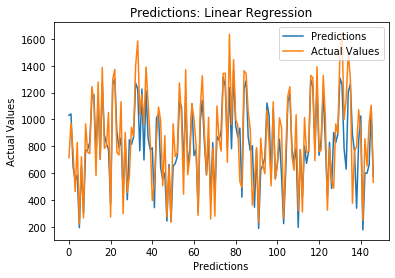

In [32]:
plot_results(results, 'Linear Regression', 'Expanding')

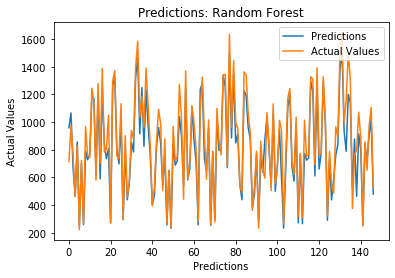

In [33]:
plot_results(results, 'Random Forest', 'Expanding')

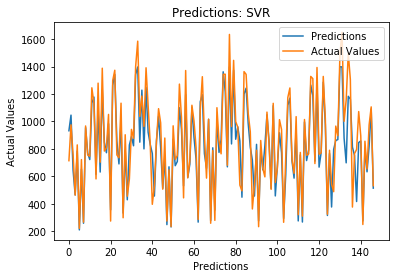

In [34]:
plot_results(results, 'SVR', 'Expanding')

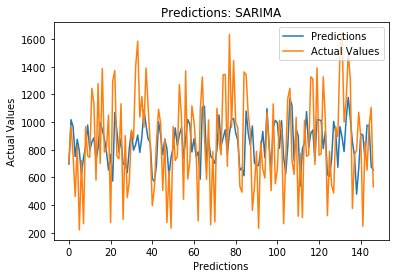

In [35]:
plot_results(results, 'SARIMA', 'Expanding')

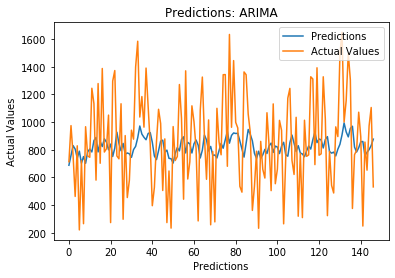

In [36]:
plot_results(results, 'ARIMA', 'Expanding')

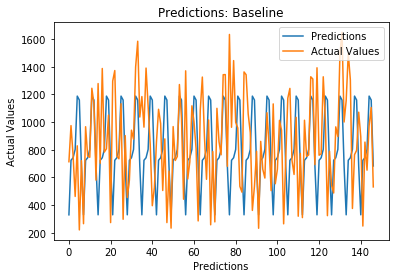

In [37]:
plot_results(results, 'Baseline', 'Expanding')

## Sliding Window

In [38]:
results = evaluate(x_train, x_test, y_train, y_test, sliding_window = True)

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 1, 7); AIC=174.891, BIC=184.616, Fit time=0.362 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=284.220, BIC=290.703, Fit time=0.030 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 7); AIC=-0.130, BIC=12.837, Fit time=0.241 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=45.237, BIC=58.204, Fit time=0.472 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=91.400, BIC=101.125, Fit time=0.051 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 7); AIC=-40.459, BIC=-24.250, Fit time=0.397 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 7); AIC=-111.798, BIC=-92.348, Fit time=0.821 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 1, 1, 7); AIC=173.653, BIC=189.862, Fit time=1.082 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 1, 1, 7); AIC=-109.363, BIC=-86.671, Fit time=1.149 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 1, 1, 7); AI

In [39]:
compute_mape(results)

Model:  Linear Regression
0.10901229411052853 18.39727806153578 132.82815461399474 20.757687288913623

Model:  Random Forest
0.04652014652015418 9.677762824915497 67.18971631205673 10.24054317892206

Model:  SVR
0.2164415665856772 12.592529975371164 155.00000042508609 20.527113028281942

Model:  SARIMA
0.3373796140613739 42.98708351890971 266.349871202014 55.67831532096396

Model:  ARIMA
0.0685741210220391 46.58359380086483 257.56640169977993 59.155348367809914

Model:  Baseline
0.30941892175372826 49.02816257122224 424.8222365869425 71.76810664431527



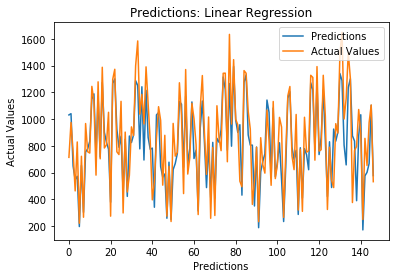

In [40]:
plot_results(results, 'Linear Regression', 'Sliding')

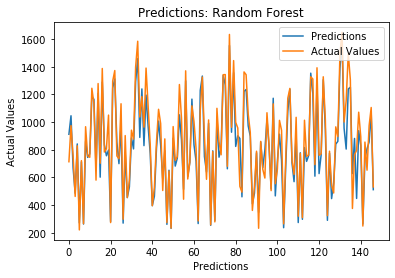

In [41]:
plot_results(results, 'Random Forest', 'Sliding')

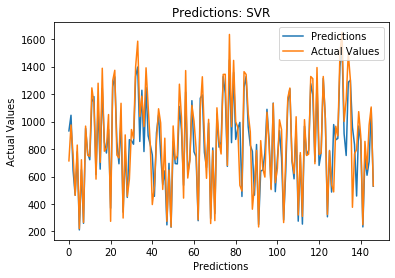

In [42]:
plot_results(results, 'SVR', 'Sliding')

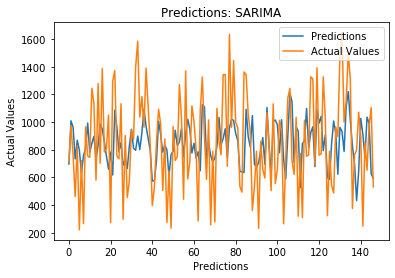

In [43]:
plot_results(results, 'SARIMA', 'Sliding')

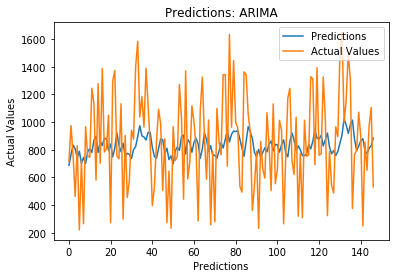

In [44]:
plot_results(results, 'ARIMA', 'Sliding')

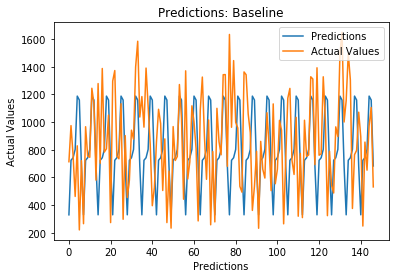

In [45]:
plot_results(results, 'Baseline', 'Sliding')

# Neural Networks

In [46]:
x_train, y_train = to_sequence(df_train)
x_test, y_test = to_sequence(df_test)

In [47]:
print(x_train.shape, y_train.shape)

(196, 1, 29) (196,)


In [48]:
dim = x_train.shape[2]

In [49]:
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

x_train = x_train.reshape((x_train.shape[0], 1, dim))
x_test = x_test.reshape((x_test.shape[0], 1, dim))

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (196, 1, 29)
Shape of test set: (147, 1, 29)
Shape of training set: (196, 1, 29)
Shape of test set: (147, 1, 29)


In [50]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

1.13.1
2.2.4


In [51]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


def evaluate_neural_net(x_train, x_test, y_train, y_test, sliding_window = False):
    sample_offseat = 1 if sliding_window else 0
    evaluation_results = {'Neural Networks' : {'predictions':[], 'actual_values':[]}}
    print('Build model...')
    model = Sequential()
    model.add(LSTM(64, dropout = 0.0, recurrent_dropout = 0.0, input_shape=(1, dim)))
    model.add(Dense(4))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience = 50, verbose = 0, mode='auto', restore_best_weights=True)
    
    yhats = []
    ys = []
    history = None
    # Train and predict with each model
    print('Training...')
    for i in range(len(y_test) - 1):
        if i % 10 == 0:
            print("Evaluating row {}/{}".format(i + 1, len(y_test) - 1))
        
        # Format the data for the neural network.
        x_val = np.array([[item] for item in x_test[i]], dtype=np.float32)
        y_val = np.array([y_test[i]], dtype=np.float32)
        
        # Build the model and predict the next row in the test set.
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), callbacks = [monitor], verbose = 0, epochs = 50)
        predictions = model.predict(x_test[i + 1].reshape(1, 1, dim))
        
        # Save results.
        yhats.append(predictions)
        ys.append(y_test[i + 1])
        
        # Add next row of the test set to the training set.
        x_train = np.vstack((x_train, x_val))
        y_train = np.append(y_train, y_val)

        x_train = x_train[sample_offseat:]
        y_train = y_train[sample_offseat:]
        

    evaluation_results['Neural Networks']['actual_values'] = list(ys)
    evaluation_results['Neural Networks']['predictions'] = list(yhats)    
    return (evaluation_results, history, model)


## Expanding Window

In [52]:
results, history, model = evaluate_neural_net(x_train, x_test, y_train, y_test, sliding_window = False)

Build model...
Instructions for updating:
Colocations handled automatically by placer.
Training...
Evaluating row 1/146
Instructions for updating:
Use tf.cast instead.
Evaluating row 11/146
Evaluating row 21/146
Evaluating row 31/146
Evaluating row 41/146
Evaluating row 51/146
Evaluating row 61/146
Evaluating row 71/146
Evaluating row 81/146
Evaluating row 91/146
Evaluating row 101/146
Evaluating row 111/146
Evaluating row 121/146
Evaluating row 131/146
Evaluating row 141/146


In [53]:
compute_mape(results)

Model:  Neural Networks
0.12382542 10.229239 86.22506 11.895113



In [54]:
results['Neural Networks']['predictions'] = [item[0] for item in results['Neural Networks']['predictions']]

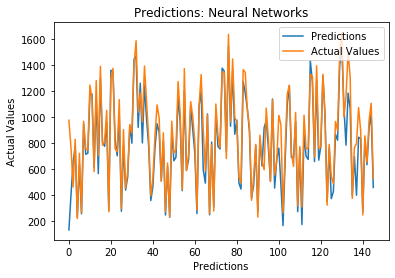

In [55]:
plot_results(results, 'Neural Networks', 'Expanding')

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                24064     
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 24,329
Trainable params: 24,329
Non-trainable params: 0
_________________________________________________________________


## Sliding Window

In [57]:
results, history, model = evaluate_neural_net(x_train, x_test, y_train, y_test, sliding_window = True)

Build model...
Training...
Evaluating row 1/146
Evaluating row 11/146
Evaluating row 21/146
Evaluating row 31/146
Evaluating row 41/146
Evaluating row 51/146
Evaluating row 61/146
Evaluating row 71/146
Evaluating row 81/146
Evaluating row 91/146
Evaluating row 101/146
Evaluating row 111/146
Evaluating row 121/146
Evaluating row 131/146
Evaluating row 141/146


In [58]:
compute_mape(results)

Model:  Neural Networks
0.11956807 10.229209 87.62625 12.18414



In [59]:
results['Neural Networks']['predictions'] = [item[0] for item in results['Neural Networks']['predictions']]

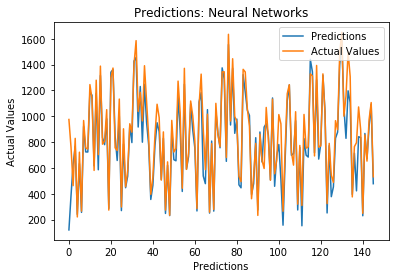

In [60]:
plot_results(results, 'Neural Networks', 'Sliding')

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                24064     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 24,329
Trainable params: 24,329
Non-trainable params: 0
_________________________________________________________________
